# Second model with fake news in spanish

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("~/TFM_fake_news_detector/data/corpus_spanish.csv")

In [3]:
df.shape

(971, 7)

In [4]:
df.isnull().sum()

Id          0
Category    0
Topic       0
Source      0
Headline    0
Text        0
Link        0
dtype: int64

#### Get the labels isolated

In [5]:
labels = df.Category
labels.head()

0    True
1    True
2    True
3    True
4    True
Name: Category, dtype: object

## Modelling

### CountVectorizer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

You can use it as follows:

Create an instance of the CountVectorizer class.
Call the fit() function in order to learn a vocabulary from one or more documents.
Call the transform() function on one or more documents as needed to encode each as a vector.
An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.

### Passive Aggressive Classifier

Passive Aggressive are considered algorithms for online learning. Their characteristic is that they remain passive when dealing with an outcome which has been correctly classified, and become aggressive when a miscalculation takes place, thus constantly self-updating and adjusting.

In [6]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
import nltk  
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

In [8]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

In [9]:
#Spanish stemmer: Stemming is the process to transform any word into its rooting word, considering them as the same word
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [10]:
#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

In [11]:
def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

In [12]:
vectorizer = CountVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

#### Split into training and test sets

In [13]:
x_train,x_test,y_train,y_test = train_test_split(df['Text'], labels, test_size=0.3, random_state=7)

In [14]:
c_train = vectorizer.fit_transform(x_train.values)
c_test = vectorizer.transform(x_test.values)

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [15]:
c_train.shape

(679, 12925)

In [16]:
c_test.shape

(292, 12925)

Initializes the Passive Aggressive Classifier

In [17]:
pa_classifier_1 = PassiveAggressiveClassifier(max_iter=50)
pa_classifier_1.fit(c_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [18]:
y_pred = pa_classifier_1.predict(c_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 78.08%


In [20]:
type(y_pred)

numpy.ndarray

In [27]:
cf_matrix = confusion_matrix(y_test,y_pred, labels=['Fake','True'])
print(cf_matrix)

[[124  26]
 [ 38 104]]


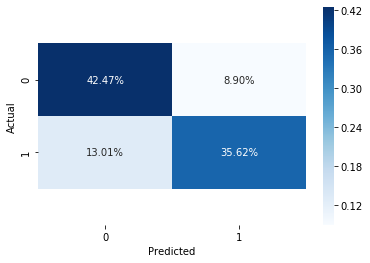

In [28]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## TfidfVectorizer

The TfidfVectorizer serves us to convert a collection of raw documents into a matrix of TF and IDF features.

### IDF (Inverse Document Frequency)

The IDF is used to calculate how many times a word appears on a set of documents.

### TF (Term Frequency)

The TF, unlike the IDF is the number of times a word appears in a single document.

#### Declare a TfidfVectorizer with stop words from English and we will allow up to a document frequency of 0.8
#### Then fit and transform it to the dataset

In [87]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

Initializes the Passive Aggressive Classifier

In [90]:
pa_classifier_2 = PassiveAggressiveClassifier(max_iter=50)
pa_classifier_2.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

## Predictions & results

In [92]:
y_pred_2 = pa_classifier_2.predict(tfidf_test)
score = accuracy_score(y_test,y_pred_2)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 92.82%


In [94]:
cf_matrix = confusion_matrix(y_test,y_pred_2, labels=['FAKE','REAL'])
print(cf_matrix)

[[591  47]
 [ 44 585]]


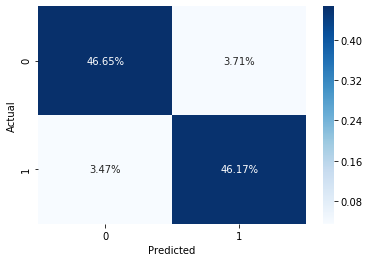

In [95]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()